In [1]:
import numpy as np
import timeit
import os
import ctypes
import numba as nb
import math


In [2]:
np.random.seed(0)
x = np.random.randint(0, 2147483646, 20, dtype=np.int32)
x

array([ 209652396,  398764591,  924231285, 1478610112,  441365315,
       1537364731,  192771779, 1491434855, 1819583497,  530702035,
        626610453, 1650906866, 1879422756, 1277901399, 1682652230,
        243580376, 1991416408, 1171049868, 1646868794, 2051556033])

In [3]:
all_mehods = []

In [4]:
def sumSqrtPurePython(x):
    sum = 0
    for e in x:
        sum += e ** 0.5
    return sum

all_mehods.append({
    'method': 'Pure Python',
    'func': sumSqrtPurePython,
    'times': []
})

# quick test:
sumSqrtPurePython(x)

647829.590943377

In [5]:
def sumSqrtMath(x):
    sum = 0
    for e in x:
        sum += math.sqrt(e)
    return sum

all_mehods.append({
    'method': 'Math Module',
    'func': sumSqrtMath,
    'times': []
})

# quick test:
sumSqrtMath(x)

647829.590943377

In [6]:
def sumSqrtNumpy(x):
    return np.sum(np.sqrt(x))

all_mehods.append({
    'method': 'Numpy',
    'func': sumSqrtNumpy,
    'times': []
})

# quick test:
sumSqrtNumpy(x)

647829.5909433769

In [7]:
@nb.njit(parallel=True)
def sumSqrtNumbaParallel(x):
    n = len(x)
    sum = 0
    for i in nb.prange(n):
        sum += x[i] ** 0.5
    return sum

all_mehods.append({
    'method': 'Numba parallel',
    'func': sumSqrtNumbaParallel,
    'times': []
})

# quick test:
sumSqrtNumbaParallel(x)

647829.590943377

In [8]:
@nb.njit
def sumSqrtNumba(x):
    n = len(x)
    sum = 0
    for i in range(n):
        sum += x[i] ** 0.5
    return sum

all_mehods.append({
    'method': 'Numba',
    'func': sumSqrtNumba,
    'times': []
})

# quick test:
sumSqrtNumba(x)

647829.590943377

In [9]:
# compiled functions
gcc_path = "C:\\__APP__\\mingw64\\bin\\gcc"
current_path = os.getcwd()

options = ['-O0', '-O1', '-O2', '-O3', '-Os', '-Ofast', '-Og', '-Oz']
sum_sqrt_libs = []
names = []

compilation_times = {}
for opt in options:
    t = timeit.timeit(lambda: os.system(f'{gcc_path} -shared {opt} -o sumSqrt{opt}.so sumSqrt.c'), number=1)
    if t<0.5:
        repeat = int(0.5/t)+1
        final_t = timeit.timeit(lambda: os.system(f'{gcc_path} -shared {opt} -o sumSqrt{opt}.so sumSqrt.c'), number=repeat)/repeat
    else:
        repeat = 1
        final_t = t
    compilation_times[opt] = final_t
    
    os.system(f'{gcc_path} -shared {opt} -o sumSqrt{opt}.so sumSqrt.c')
    lib = ctypes.cdll.LoadLibrary(os.path.join(current_path, f'sumSqrt{opt}.so'))
    lib.sumSqrtC.argtypes = (ctypes.POINTER(ctypes.c_int), ctypes.c_int)
    lib.sumSqrtC.restype = ctypes.c_double
    sum_sqrt_libs.append(lib)
    names.append(f'compiled{opt}')


def np_to_c(arr: np.ndarray) -> tuple[ctypes.POINTER(ctypes.c_int), ctypes.c_int]:
    return arr.ctypes.data_as(ctypes.POINTER(ctypes.c_int)), ctypes.c_int(len(arr))

def sumSqrtC(x, lib):
    return lib.sumSqrtC(*np_to_c(x))

all_mehods.append({
    'method': 'C -O0',
    'func': lambda x: sumSqrtC(x, lib=sum_sqrt_libs[0]),
    'times': []
})
all_mehods.append({
    'method': 'C -O1',
    'func': lambda x: sumSqrtC(x, lib=sum_sqrt_libs[1]),
    'times': []
})
all_mehods.append({
    'method': 'C -O2',
    'func': lambda x: sumSqrtC(x, lib=sum_sqrt_libs[2]),
    'times': []
})
all_mehods.append({
    'method': 'C -O3',
    'func': lambda x: sumSqrtC(x, lib=sum_sqrt_libs[3]),
    'times': []
})
all_mehods.append({
    'method': 'C -Os',
    'func': lambda x: sumSqrtC(x, lib=sum_sqrt_libs[4]),
    'times': []
})
all_mehods.append({
    'method': 'C -Ofast',
    'func': lambda x: sumSqrtC(x, lib=sum_sqrt_libs[5]),
    'times': []
})
all_mehods.append({
    'method': 'C -Og',
    'func': lambda x: sumSqrtC(x, lib=sum_sqrt_libs[6]),
    'times': []
})
all_mehods.append({
    'method': 'C -Oz',
    'func': lambda x: sumSqrtC(x, lib=sum_sqrt_libs[7]),
    'times': []
})

print('Compilation times:')
for opt, t in compilation_times.items():
    print(f'{opt}: {t:.3f} s')

# quick test:
sumSqrtC(x, lib=sum_sqrt_libs[0])

Compilation times:
-O0: 0.255 s
-O1: 0.279 s
-O2: 0.261 s
-O3: 0.256 s
-Os: 0.319 s
-Ofast: 0.295 s
-Og: 0.280 s
-Oz: 0.264 s


647829.590943377

In [10]:
os.system('python setup.py build_ext --inplace')

import sumSqrtCython

all_mehods.append({
    'method': 'Cython',
    'func': sumSqrtCython.sumSqrtCython,
    'times': []
})

# quick test:
sumSqrtCython.sumSqrtCython(x)

647829.5909433769

In [11]:
all_mehods

[{'method': 'Pure Python',
  'func': <function __main__.sumSqrtPurePython(x)>,
  'times': []},
 {'method': 'Math Module',
  'func': <function __main__.sumSqrtMath(x)>,
  'times': []},
 {'method': 'Numpy', 'func': <function __main__.sumSqrtNumpy(x)>, 'times': []},
 {'method': 'Numba parallel',
  'func': CPUDispatcher(<function sumSqrtNumbaParallel at 0x0000023027BAC360>),
  'times': []},
 {'method': 'Numba',
  'func': CPUDispatcher(<function sumSqrtNumba at 0x0000023027BAC220>),
  'times': []},
 {'method': 'C -O0', 'func': <function __main__.<lambda>(x)>, 'times': []},
 {'method': 'C -O1', 'func': <function __main__.<lambda>(x)>, 'times': []},
 {'method': 'C -O2', 'func': <function __main__.<lambda>(x)>, 'times': []},
 {'method': 'C -O3', 'func': <function __main__.<lambda>(x)>, 'times': []},
 {'method': 'C -Os', 'func': <function __main__.<lambda>(x)>, 'times': []},
 {'method': 'C -Ofast', 'func': <function __main__.<lambda>(x)>, 'times': []},
 {'method': 'C -Og', 'func': <function __m

In [12]:
%%timeit
sumSqrtPurePython(x)

49.8 µs ± 6.27 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [13]:
%%timeit
sumSqrtMath(x)

7.06 µs ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [14]:
%%timeit
sumSqrtNumpy(x)

6.6 µs ± 349 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [15]:
%%timeit
sumSqrtC(x, lib=sum_sqrt_libs[0])

5.83 µs ± 643 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [16]:
%%timeit
sumSqrtC(x, lib=sum_sqrt_libs[1])

4.9 µs ± 242 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [17]:
%%timeit
sumSqrtCython.sumSqrtCython(x)

11.5 µs ± 439 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [18]:
%%timeit
sumSqrtNumba(x)

583 ns ± 77.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [19]:
%%timeit
sumSqrtNumbaParallel(x)

23.2 µs ± 3.89 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [20]:
print('Speed tests:')
for i in range(1,9):
    n = 10**i
    np.random.seed(0)
    x = np.random.randint(0, 2147483646, n, dtype=np.int32)
    print(f'Taille 10^{i}:')
    for method in all_mehods:
        if i > 6 and method['method'] == 'Pure Python':
            continue
        if i > 7 and method['method'] == 'Math Module':
            continue
        func = method['func']
        t = timeit.timeit(lambda: func(x), number=1)
        if t<0.5:
            repeat = int(0.5/t)+1
            final_t = timeit.timeit(lambda: func(x), number=repeat)/repeat
        else:
            repeat = 1
            final_t = t
        method['times'].append(final_t)
        print(f'\t{method["method"]}: {final_t:0.7f}s (repeats: {repeat})')

Speed tests:
Taille 10^1:
	Pure Python: 0.0000350s (repeats: 7003)
	Math Module: 0.0000046s (repeats: 47619)
	Numpy: 0.0000073s (repeats: 10639)
	Numba parallel: 0.0000201s (repeats: 8026)
	Numba: 0.0000011s (repeats: 106383)
	C -O0: 0.0000075s (repeats: 12166)
	C -O1: 0.0000078s (repeats: 14620)
	C -O2: 0.0000064s (repeats: 17007)
	C -O3: 0.0000055s (repeats: 14620)
	C -Os: 0.0000060s (repeats: 14493)
	C -Ofast: 0.0000062s (repeats: 13813)
	C -Og: 0.0000045s (repeats: 14006)
	C -Oz: 0.0000057s (repeats: 12691)
	Cython: 0.0000140s (repeats: 7236)
Taille 10^2:
	Pure Python: 0.0002394s (repeats: 2222)
	Math Module: 0.0000260s (repeats: 18657)
	Numpy: 0.0000083s (repeats: 9209)
	Numba parallel: 0.0000216s (repeats: 6106)
	Numba: 0.0000012s (repeats: 100000)
	C -O0: 0.0000077s (repeats: 13737)
	C -O1: 0.0000054s (repeats: 12987)
	C -O2: 0.0000070s (repeats: 15385)
	C -O3: 0.0000059s (repeats: 12078)
	C -Os: 0.0000075s (repeats: 10684)
	C -Ofast: 0.0000055s (repeats: 15975)
	C -Og: 0.000008

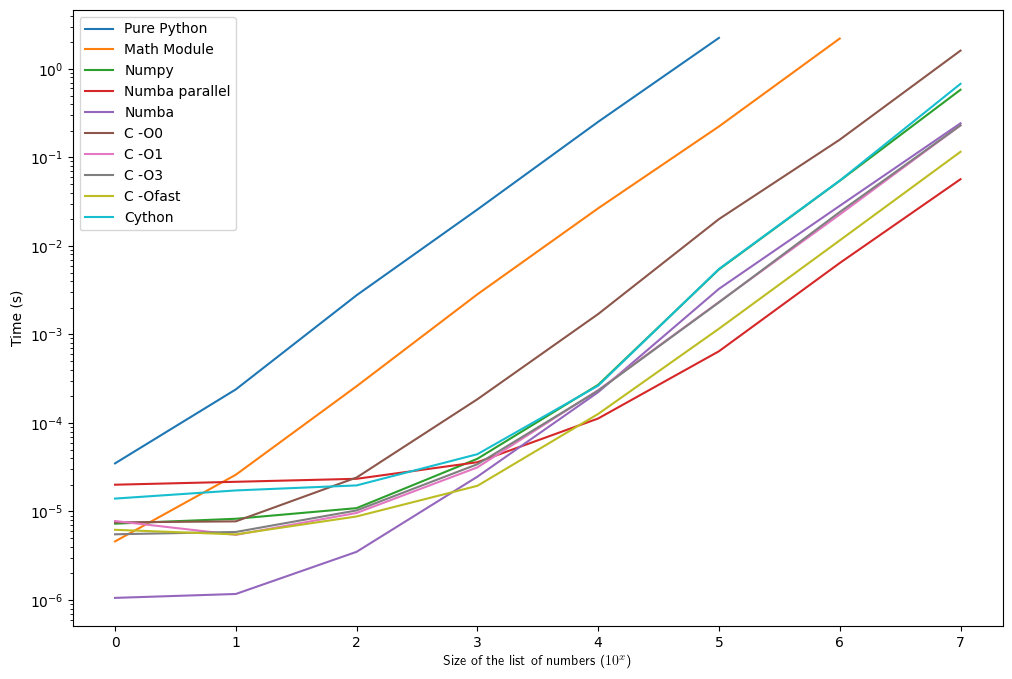

In [23]:
import matplotlib.pyplot as plt

to_ignore = ['C -Oz', 'C -Os', 'C -Og', 'C -O2']
plt.figure(figsize=(12, 8))
for method in all_mehods:
    if method['method'] in to_ignore:
        continue
    plt.semilogy(method['times'], label=method['method'])
plt.legend()
plt.xlabel('Size of the list of numbers ($10^x$)', usetex=True)
plt.ylabel('Time (s)')
plt.show()